In [16]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import KFold, GridSearchCV
import plotly.graph_objects as go
import os

DATA_PATH = 'raw_data/full_data/'
YIZI_DATA_PATH = 'raw_data/yizi_data/'

# seed = 666
# set_seed(seed)

In [2]:
def get_data(data_path, recording_ids):
    files = os.listdir(data_path)
    X_files = [f for f in files if f.endswith('.npy') and f.startswith('X')]
    X_files.sort()
    Y_files = [f for f in files if f.endswith('.npy') and f.startswith('Y')]
    Y_files.sort()

    X_files = np.array(X_files)
    Y_files = np.array(Y_files)

    X_list = [np.load(data_path + f) for f in X_files[recording_ids]]
    Y_list = [np.load(data_path + f) for f in Y_files[recording_ids]]

    return X_list, Y_list

### Functionality

In [3]:
def time_bin_wise_metrics(y_true, y_pred):
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    corr = pearsonr(y_true.flatten(), y_pred.flatten())[0]
    mse = np.mean((y_true.flatten() - y_pred.flatten())**2)
    return r2, corr, mse

def continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False, verbose=True):
    penalty = [0.001, 0.01, 1, 10, 100, 1000]
    
    train_K, test_K = len(train_X), len(test_X)
    _, C, T = train_X.shape
    if time_independent:
        train_X = np.moveaxis(train_X, 1, -1).reshape((-1, C))
        test_X = np.moveaxis(test_X, 1, -1).reshape((-1, C))
        train_Y = train_Y.reshape((-1))
        test_Y = test_Y.reshape((-1))
        if verbose:
            print("time-independent:")
    else:
        train_X = np.moveaxis(train_X, 1, -1).reshape((-1, T*C))
        test_X = np.moveaxis(test_X, 1, -1).reshape((-1, T*C))
        if verbose:
            print("time-dependent:")
    
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)
    
    if time_independent:
        r2, corr, mse = time_bin_wise_metrics(test_Y, pred_Y)
    else:
        r2, corr, mse = time_bin_wise_metrics(test_Y, pred_Y)
        
    if verbose:
        print(f"r2: {r2:.3f} corr: {corr:.3f} mse: {mse:.3f}")
    
    return pred_Y, [r2, corr]

def sliding_window_over_time(data, half_window_size=3):
    
    window_size = 2*half_window_size + 1
    
    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - 2*half_window_size, window_size
        ))
        for t in range(n_t_bins - 2*half_window_size):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t + d]
            data_window[:,:,t] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        max_len = n_t_bins - 2*half_window_size
        data_window = np.zeros((n_trials, max_len, window_size))
        for t in range(max_len):
            data_window[:,t] = data[:,t:t+window_size]
        data_window = data_window[:,:,half_window_size]
    return data_window

def sliding_window_decoder(train_X, train_Y, test_X, test_Y, verbose=True):
    penalty = [0.001, 0.01, 1, 10, 100, 1000]
    
    train_K, C, T, L = train_X.shape
    test_K, _, _, _ = test_X.shape
    
    train_X = train_X.transpose(0,1,-1,2).reshape(train_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    test_X = test_X.transpose(0,1,-1,2).reshape(test_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    train_Y = train_Y.reshape((-1))
    test_Y = test_Y.reshape((-1))
    
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)
    
    r2, corr, mse = time_bin_wise_metrics(test_Y, pred_Y)
    if verbose:
        print("sliding-window:")
        print(f"r2: {r2:.3f} corr: {corr:.3f} mse: {mse:.3f}")
    
    return pred_Y, [r2, corr]

In [4]:
class ReducedRankRegression(torch.nn.Module):    
    def __init__(self, n_c, n_t, n_r):
        super(ReducedRankRegression, self).__init__()
        self.U = torch.nn.Parameter(torch.randn(n_c, n_r))
        self.V = torch.nn.Parameter(torch.randn(n_r, n_t))
        self.b = torch.nn.Parameter(torch.randn(1,))
        
    def forward(self, x):
        self.beta = self.U @ self.V
        out = torch.einsum("ct,kct->kt", self.beta, x)
        out += self.b
        return out
    
def train_rrr(
    X, 
    Y, 
    train,
    test,
    n_r = 10,
    learning_rate=1e-3,
    n_epochs=10000,
    ):
    
    _, n_c, n_t = X.shape
    rrr = ReducedRankRegression(n_c, n_t, n_r)
    optimizer = torch.optim.Adam(rrr.parameters(), lr=learning_rate, weight_decay=1e-3)
    criterion = torch.nn.MSELoss()
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    train_x, test_x = X[train], X[test]
    train_y, test_y = Y[train], Y[test]
    
    losses = []
    for epoch in tqdm(range(n_epochs), desc="Train RRR:"):
        optimizer.zero_grad()
        y_pred = rrr(train_x)
        loss = criterion(y_pred, train_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return rrr, losses

### Load Data

In [5]:
neural_data = np.load(f"{YIZI_DATA_PATH}neural_data.npy", allow_pickle=True).item()
behavior_data = np.load(f"{YIZI_DATA_PATH}behavior_data.npy", allow_pickle=True).item()
print(neural_data.keys())
print(behavior_data.keys())

# Probably recording: dab512bd-a02d-4c1f-8dbc-9155a163efc0

X = neural_data["po"]
Y = behavior_data["wheel_speed"]
K, C, T = X.shape
print(X.shape)
print(Y.shape)

dict_keys(['po', 'lp', 'dg', 'ca1', 'vis'])
dict_keys(['wheel_speed', 'motion_energy', 'pupil_diameter', 'paw_speed'])
(367, 159, 50)
(367, 50)


In [6]:
# # X_list, Y_list = get_data(DATA_PATH, [89])
# X_list, Y_list = get_data(DATA_PATH, [1])
# X = X_list[0]
# Y = Y_list[0]
# K, C, T = X.shape
# print(X.shape)
# print(Y.shape)

In [7]:
# data preprocessing
smooth_X = np.array(
    [[gaussian_filter1d(X[k, c, :], 4) for c in range(C)] for k in range(K)]
)
smooth_Y = np.array([gaussian_filter1d(Y[k, :], 4) for k in range(K)])
# smooth_X = X
# smooth_Y = Y
norm_Y = smooth_Y / smooth_Y.max() # to prevent gradient explosion

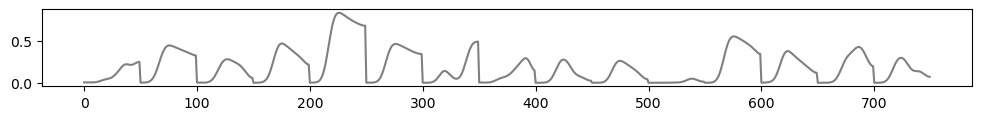

In [8]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[10:10+15].flatten(), c="gray")
plt.show()

### Find time offset for each brain region

In [22]:
kf = KFold(n_splits=5, shuffle=True)

In [23]:
# # this code takes a long time to run
# time_lag = {}
# for l in [10]:
#     print(f"time lag = {l*20} ms")
#     window_X = sliding_window_over_time(smooth_X, half_window_size=l)
#     window_Y = sliding_window_over_time(norm_Y, half_window_size=l)
#     mean_r2 = []
#     for train, test in kf.split(smooth_X):
#         train_X, test_X = window_X[train], window_X[test]
#         train_Y, test_Y = window_Y[train], window_Y[test]
#         _, metrics = sliding_window_decoder(train_X, train_Y, test_X, test_Y, verbose=False)
#         mean_r2.append(metrics[0])
#     print(f"5-fold CV R2 = {np.mean(mean_r2):.3f}")
#     time_lag.update({l: np.mean(mean_r2)})

In [24]:
# best_lag = max(time_lag, key=time_lag.get)
# print(f"best time lag is {best_lag*20} ms.")

For the following analysis, use the same train and test set:

In [25]:
for train, test in kf.split(X):
    pass
print(test)

[  1   2   9  10  21  27  32  42  44  47  53  60  61  78  80  81  82  83
  97 108 109 113 118 122 123 126 129 135 136 138 142 143 146 149 150 153
 155 160 162 164 171 175 187 193 210 215 223 228 230 234 238 244 245 255
 256 271 282 287 297 298 305 307 310 318 319 322 323 324 335 336 342 348
 361]


#### Baseline

In [13]:
train_X, test_X = smooth_X[train], smooth_X[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:


r2: 0.534 corr: 0.740 mse: 0.014
time-dependent:
r2: 0.618 corr: 0.791 mse: 0.011


In [26]:
best_lag = 10
window_X = sliding_window_over_time(smooth_X, half_window_size=best_lag)
window_Y = sliding_window_over_time(norm_Y, half_window_size=best_lag)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
y_pred, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

sliding-window:
r2: 0.587 corr: 0.780 mse: 0.011


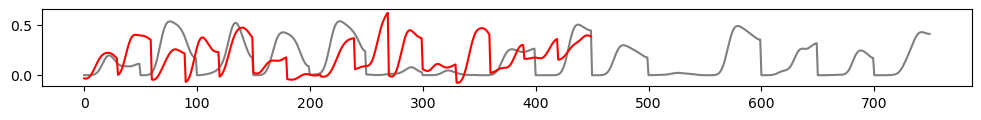

In [27]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[test][10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

## Does this actually work?

In [17]:
print(norm_Y[test].shape)

(73, 50)


In [21]:
for t in range(5):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=norm_Y[test][t], name='Original'))
    fig.add_trace(go.Scatter(y=y_pred[t], name='Prediction'))
    fig.update_layout(title=f'Original, Smoothed, and Mean Subtracted Wheel Speeds, Recording 0, Trial {t}', xaxis_title='Time', yaxis_title='Value')
    fig.show()